In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks/files/project" #dont forget that first slash

Mounted at /content/drive
africa_wordcloud.png	       nd_India_wordcloud.png
aussy_wordcloud.png	       neg_wordcloud.png
china_wordcloud.png	       NY_wordcloud.png
covid19_news.csv	       pos_wordcloud.png
covid19_tweets.csv	       singapore_wordcloud.png
covid19_twitter_full.csv       twitter_wordcloud_blank.png
covid19_twitter_sentiment.csv  US_wordcloud.png
London_wordcloud.png


# Load packages

In [2]:
!pip install textblob
!pip install wordcloud
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 17.6 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=75aea94d33999900387c2bce4dde5921ca5c3d6f407f9d7e8fb20e137cbc7e1d
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


The below step is for integrating GPUs (did not use)

In [ ]:
#!pip install numba
#!find / -iname 'libdevice'
#!find / -iname 'libnvvm.so'


Import libraries.

In [3]:
# import libraries
import pandas as pd
import numpy as np

# Text processing
import re 
from textblob import TextBlob
import string

# Word cloud visualization
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

# Machine learning (sentiment analysis)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# This one will be used to help us with lexicon
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Other visualization
import matplotlib.pyplot as plt
import plotly.express as px


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [41]:
twitter_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/files/project/covid19_tweets.csv")
twitter_data_classified = pd.read_csv("/content/drive/My Drive/Colab Notebooks/files/project/covid19_twitter_full.csv") #data with sentiment classified; to speed up my progress

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,1,2,3,4,6,7,8,9,10,11,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:
twitter_data_raw = pd.read_csv("/content/drive/My Drive/Colab Notebooks/files/project/covid19_tweets.csv") #added this after observing issues with positive tweets

In [ ]:
#did not use news data eventually
news_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/files/project/covid19_news.csv")

Look at attributes of columns in data.

In [16]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_name         179108 non-null  object 
 1   user_location     142337 non-null  object 
 2   user_description  168822 non-null  object 
 3   user_created      179108 non-null  float64
 4   user_followers    179108 non-null  int64  
 5   user_friends      179108 non-null  int64  
 6   user_favourites   179108 non-null  int64  
 7   user_verified     179108 non-null  bool   
 8   date              179108 non-null  object 
 9   text              179108 non-null  object 
 10  hashtags          127774 non-null  object 
 11  source            179031 non-null  object 
 12  is_retweet        179108 non-null  bool   
dtypes: bool(2), float64(1), int64(3), object(7)
memory usage: 15.4+ MB


In [17]:
twitter_data.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,42881.24076,624,950,18775,False,7/25/2020,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",39919.83777,2253,1677,24,True,7/25/2020,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,39872.79006,9275,9525,7254,False,7/25/2020,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,43531.07299,197,987,1488,False,7/25/2020,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,42778.28142,101009,168,101,False,7/25/2020,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [18]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sno          4072 non-null   int64 
 1   Date         4072 non-null   object
 2   Headline     4072 non-null   object
 3   Covid        4072 non-null   int64 
 4   Sentiment    4072 non-null   int64 
 5   Description  4072 non-null   object
 6   Image        4072 non-null   object
 7   Source       4072 non-null   object
dtypes: int64(3), object(5)
memory usage: 254.6+ KB


you lose context of words when rating positivity or negativity with the bag of words approach. could that be happening here?

# Data cleaning

### Twitter

Remove NA or missing values.

In [19]:
twitter_data.isna().sum()

user_name               0
user_location       36771
user_description    10286
user_created            0
user_followers          0
user_friends            0
user_favourites         0
user_verified           0
date                    0
text                    0
hashtags            51334
source                 77
is_retweet              0
dtype: int64

Judging from missingness, location, userdescription, and hashtags may need to be dropped.

However: we have 179,095 lines of data, and even after dropping the NAs, we still have enough data for analysis.

Another thing we could do: replace location NAs with 'unknown' and keep location for network analysis, but many locations are made-up and might not give us good insights.

Remove duplicates.

#### For first round of data cleaning:

In [20]:
twitter_data.drop_duplicates(inplace=True)
news_data.drop_duplicates(inplace=True)

Remove irrelevant columns and drop NAs.

In [21]:
twitter_data = twitter_data.dropna(axis=0)

In [81]:
twitter_data = twitter_data.drop(['user_name','user_created','source','is_retweet','user_description'], axis=1)

dropped these variables because they are relatively arbitrary and difficult to extract useful information from in the context of this project. user description had other languages (Russian, for example) and was beyond the scope of this project. The source of the post also did not make a big difference--Android and iPhone users are not that different.

In [77]:
twitter_data.info()
twitter_data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8279 entries, 57 to 179073
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_name         8279 non-null   object 
 1   user_location     8279 non-null   object 
 2   user_description  8279 non-null   object 
 3   user_created      8279 non-null   float64
 4   user_followers    8279 non-null   int64  
 5   user_friends      8279 non-null   int64  
 6   user_favourites   8279 non-null   int64  
 7   user_verified     8279 non-null   bool   
 8   date              8279 non-null   object 
 9   text              8279 non-null   object 
 10  hashtags          8279 non-null   object 
 11  source            8279 non-null   object 
 12  is_retweet        8279 non-null   bool   
dtypes: bool(2), float64(1), int64(3), object(7)
memory usage: 792.3+ KB


user_name           0
user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
is_retweet          0
dtype: int64

After dropping duplicates, deleting irrelevant columns, and deleting NULL values, I was left with 99,127 rows of data, which is more than enough to conduct my analyses.

In [78]:
remove_rt = lambda x: re.sub("RT @\w+: ","",x)
rt = lambda x: re.sub('(@[A-Za-z0-9]+)'," ",x)

twitter_data['text'] = twitter_data['text'].map(remove_rt).map(rt) #did not work with the dataset that classified sentiments; perhaps changed datatypes when saving?
#twitter_data['text'] = map(remove_rt,list(twitter_data['text']))
#twitter_data['text'] = twitter_data['text'].str.lower() #should not do this step bc VADER recognizes caps

In [79]:
remove_hashtag = lambda x: re.sub("#\S+", "", x)
twitter_data['text_nohash'] = twitter_data['text'].map(remove_hashtag)

In [82]:
twitter_data.head()

,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,text_nohash
57,"New Orleans, LA",11,3,133,False,7/25/2020,Crazy that the world has come to this but as A...,['covid19'],Crazy that the world has come to this but as A...
61,astroworld,624,950,18775,False,7/25/2020,I miss isopropyl alcohol so much!!!! Ethanol i...,['COVID19'],I miss isopropyl alcohol so much!!!! Ethanol i...
102,"near Austin, Texas",876,777,1640,False,7/25/2020,Not only is the area about to be hit by #hanna...,"['hanna', 'COVID19']",Not only is the area about to be hit by a ho...
103,"Toronto, Ontario, Canada",738,143,28004,False,7/25/2020,1.28% of the U.S. population is infected with ...,"['COVID19', 'TrumpVirus', 'MaskItOrCasket']",1.28% of the U.S. population is infected with ...
118,Universe,2181,1928,25969,False,7/25/2020,If CM of Madhya Pradesh is tested positive for...,['COVID19'],If CM of Madhya Pradesh is tested positive for...


Lambda fucntion: apply the same operation on a given subset of the data

A lambda function is a small function containing a single expression. Lambda functions can also act as anonymous functions where they don’t require any name. These are very helpful when we have to perform small tasks with less code.

Lambda functions consist of three parts: for ex:

lambda x: re.sub("RT @\w+: ","",x)

-Keyword (lambda) -Bound variable/argument, and (x) -Body or expression (re.sub("RT @\w+: ","",x)) The keyword is mandatory, and it must be a lambda, whereas the arguments and body can change based on the requirements.

regular expressions: we use the "re" (stands for 'regular expression') library to build an expression that reflects patterns in the text we want to find. 

Remove mentions from text with lambda function.

Note for future analysis: Perhaps consider adding in placeholders for @s?

#### Second round of cleaning:

In [47]:
#def twitter_cleaner(x):
  #x = x.drop_duplicates(inplace=True)
  #x = x.dropna(axis=0)
  #x = x.drop(['user_name','user_created','source','is_retweet','user_description'], axis=1)
  #return x

In [74]:
twitter_data_new = twitter_data_raw.drop_duplicates(inplace=True)

In [58]:
twitter_data_new = twitter_data_raw.dropna(axis=0)

In [73]:
twitter_data_new = twitter_data_raw.drop(['user_name','user_created','source','is_retweet','user_description'], axis=1)

In [53]:
twitter_data_new['text'] = twitter_data_raw['text'].map(remove_rt).map(rt)
twitter_data_new['text_nohash'] = twitter_data_raw['text'].map(remove_hashtag)

In [62]:
twitter_data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99129 entries, 2 to 179106
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_name         99129 non-null  object 
 1   user_location     99129 non-null  object 
 2   user_description  99129 non-null  object 
 3   user_created      99129 non-null  float64
 4   user_followers    99129 non-null  int64  
 5   user_friends      99129 non-null  int64  
 6   user_favourites   99129 non-null  int64  
 7   user_verified     99129 non-null  bool   
 8   date              99129 non-null  object 
 9   text              99129 non-null  object 
 10  hashtags          99129 non-null  object 
 11  source            99129 non-null  object 
 12  is_retweet        99129 non-null  bool   
dtypes: bool(2), float64(1), int64(3), object(7)
memory usage: 9.3+ MB


In [68]:
#delete all posts with hashtags
twitter_data = twitter_data_new[~twitter_data_new.text.str.contains("https*\S+")]

In [84]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8279 entries, 57 to 179073
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_location    8279 non-null   object
 1   user_followers   8279 non-null   int64 
 2   user_friends     8279 non-null   int64 
 3   user_favourites  8279 non-null   int64 
 4   user_verified    8279 non-null   bool  
 5   date             8279 non-null   object
 6   text             8279 non-null   object
 7   hashtags         8279 non-null   object
 8   text_nohash      8279 non-null   object
dtypes: bool(1), int64(3), object(5)
memory usage: 590.2+ KB


### News data (did not use)

Check missing values.

In [52]:
news_data.isna().sum()

Sno            0
Date           0
Headline       0
Covid          0
Sentiment      0
Description    0
Image          0
Source         0
dtype: int64

Drop columns that we won't be using.

In [16]:
news_data = news_data.drop(['Sno','Source'], axis=1)

In [19]:
news_data.head(3)

,Date,Headline,Covid,Sentiment,Description,Image
0,2020-04-29,"Coronavirus cases reach 2,438 in Rajasthan; 81...",1,0,Rajasthan on Wednesday reported 74 new coronav...,https://static.inshorts.com/inshorts/images/v1...
1,2020-04-29,"Coronavirus cases in Delhi surge to 3,439 afte...",1,0,The total number of coronavirus cases in Delhi...,https://static.inshorts.com/inshorts/images/v1...
2,2020-04-30,"Anguished, I'll always recall our interactions...",0,1,"Condoling the demise of actor Rishi Kapoor, PM...",https://static.inshorts.com/inshorts/images/v1...


In [21]:
news_data['description_len'] = news_data['Description'].astype(str).apply(len)
news_data['description_word_count'] = news_data['Description'].apply(lambda x: len(str(x).split())) #default is whitespace; not super useful

In [24]:
news_data['Description'] = news_data['Description'].str.lower()

In [25]:
news_data.head()

,Date,Headline,Covid,Sentiment,Description,Image,description_len,description_word_count
0,2020-04-29,"Coronavirus cases reach 2,438 in Rajasthan; 81...",1,0,rajasthan on wednesday reported 74 new coronav...,https://static.inshorts.com/inshorts/images/v1...,343,59
1,2020-04-29,"Coronavirus cases in Delhi surge to 3,439 afte...",1,0,the total number of coronavirus cases in delhi...,https://static.inshorts.com/inshorts/images/v1...,314,55
2,2020-04-30,"Anguished, I'll always recall our interactions...",0,1,"condoling the demise of actor rishi kapoor, pm...",https://static.inshorts.com/inshorts/images/v1...,382,60
3,2020-04-30,It's a terrible week for Indian cinema: Rahul ...,0,0,congress leader rahul gandhi condoled rishi ka...,https://static.inshorts.com/inshorts/images/v1...,375,59
4,2020-04-30,Delhi Police perform 'parikrama' of AIIMS to t...,1,1,as a sign of respect for healthcare profession...,https://static.inshorts.com/inshorts/images/v1...,363,59


In [26]:
news_covid = news_data[news_data['Covid']==1]
news_other = news_data[news_data['Covid']==0]

In [53]:
news_covid.describe()

,Covid,Sentiment,description_len,description_word_count
count,3245.0,3245.000000,3245.000000,3245.000000
mean,1.0,0.369800,360.397227,58.153467
std,0.0,0.482825,24.785336,2.383899
min,1.0,0.000000,282.000000,46.000000
25%,1.0,0.000000,343.000000,57.000000
50%,1.0,0.000000,362.000000,59.000000
75%,1.0,1.000000,380.000000,60.000000
max,1.0,1.000000,400.000000,60.000000


# Exploratory analysis

## Twitter

### Summary

In [75]:
#summary of numeric variables
twitter_data.describe()

,user_created,user_followers,user_friends,user_favourites
count,8279.000000,8.279000e+03,8279.000000,8279.000000
mean,41531.554148,3.649485e+04,2059.551516,21217.688247
std,1411.840481,3.583273e+05,8211.415707,48756.404552
min,38915.056840,0.000000e+00,0.000000,0.000000
25%,40298.961685,1.515000e+02,209.000000,717.000000
50%,41162.810210,6.680000e+02,656.000000,4205.000000
75%,42813.202650,2.643500e+03,1915.500000,18084.000000
max,44073.281490,1.347733e+07,445635.000000,738087.000000


In [85]:
twitter_data.describe(include='object')

,user_location,date,text,hashtags,text_nohash
count,8279,8279,8279,8279,8279
unique,3866,26,8131,3506,8125
top,United States,7/25/2020,Protect GI research during #COVID19. Support...,['COVID19'],Ensure access to testing in minority commun...
freq,196,783,7,3236,7


In [137]:
#remove_https = lambda x: re.sub('https*\S+', "", x)
#twitter_data['text'] = twitter_data['text'].map(remove_https)
#twitter_data['text_nohash'] = twitter_data['text_nohash'].map(remove_https)

In [86]:
twitter_data.head()

,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,text_nohash
57,"New Orleans, LA",11,3,133,False,7/25/2020,Crazy that the world has come to this but as A...,['covid19'],Crazy that the world has come to this but as A...
61,astroworld,624,950,18775,False,7/25/2020,I miss isopropyl alcohol so much!!!! Ethanol i...,['COVID19'],I miss isopropyl alcohol so much!!!! Ethanol i...
102,"near Austin, Texas",876,777,1640,False,7/25/2020,Not only is the area about to be hit by #hanna...,"['hanna', 'COVID19']",Not only is the area about to be hit by a ho...
103,"Toronto, Ontario, Canada",738,143,28004,False,7/25/2020,1.28% of the U.S. population is infected with ...,"['COVID19', 'TrumpVirus', 'MaskItOrCasket']",1.28% of the U.S. population is infected with ...
118,Universe,2181,1928,25969,False,7/25/2020,If CM of Madhya Pradesh is tested positive for...,['COVID19'],If CM of Madhya Pradesh is tested positive for...


In [87]:
#summary of objects
twitter_data.describe(include=['object'])

,user_location,date,text,hashtags,text_nohash
count,8279,8279,8279,8279,8279
unique,3866,26,8131,3506,8125
top,United States,7/25/2020,Protect GI research during #COVID19. Support...,['COVID19'],Ensure access to testing in minority commun...
freq,196,783,7,3236,7


Time span is quite short, and it might be hard to see big sentiment changes over time. But still worth a try (show fluctuations of # of twitter posts over time).

Location is worth investigating since there are over 20k unqiue ones.

hashtags might also be something to look at.

is_retweet all had the same value, so maybe don't focus on this too much (no difference).

### Locations

In [88]:
#locations
locations = list(twitter_data['user_location'].unique())
print(locations)

['New Orleans, LA', 'astroworld', 'near Austin, Texas', 'Toronto, Ontario, Canada', 'Universe', 'Stevenage, Hertfordshire, UK ', 'Central Illinois via Western WA', 'New Delhi, India', 'Blainville, Québec', 'Massachusetts, USA', 'Massachusetts ', 'Jefferson City, MO', 'UK', 'Canada', 'North Shore, Boston ', 'PDX', 'Birmingham ', 'Rochester NY Toronto ON', 'Gloucestershire UK', 'Toronto', 'Florida, USA', 'United States', 'New York / Chicago / Tampa', 'South Africa', 'God Is Able', 'Delhi', 'NC', 'Las Vegas/Los Angeles', 'Scotland', 'Worldwide', 'The Matrix', 'chelmsford, essex', 'Weirdoland 😀', 'South West', 'Tamil Nadu, India', '#MaskUpNigeria ', 'mumbai', 'Brisbane, Queensland', 'UK - and beyond', 'Nairobi, Kenya', 'भारत🇮🇳', 'Texas', 'Adelaide, Australia', 'iowa city, iowa', 'Bihar, India', 'Zirakpur', 'Faisalabad', 'Texas, USA', 'Alphabet City', 'Soshanguve, South Africa', 'Longbenton, England', 'lagos', 'Liverpool, EUROPE!', 'Cambridge, UK', 'London UK', 'Earth ', 'Jacksonville FL ',

In [89]:
import collections
frequency = collections.Counter(locations)
print(dict(frequency))

{'New Orleans, LA': 1, 'astroworld': 1, 'near Austin, Texas': 1, 'Toronto, Ontario, Canada': 1, 'Universe': 1, 'Stevenage, Hertfordshire, UK ': 1, 'Central Illinois via Western WA': 1, 'New Delhi, India': 1, 'Blainville, Québec': 1, 'Massachusetts, USA': 1, 'Massachusetts ': 1, 'Jefferson City, MO': 1, 'UK': 1, 'Canada': 1, 'North Shore, Boston ': 1, 'PDX': 1, 'Birmingham ': 1, 'Rochester NY Toronto ON': 1, 'Gloucestershire UK': 1, 'Toronto': 1, 'Florida, USA': 1, 'United States': 1, 'New York / Chicago / Tampa': 1, 'South Africa': 1, 'God Is Able': 1, 'Delhi': 1, 'NC': 1, 'Las Vegas/Los Angeles': 1, 'Scotland': 1, 'Worldwide': 1, 'The Matrix': 1, 'chelmsford, essex': 1, 'Weirdoland 😀': 1, 'South West': 1, 'Tamil Nadu, India': 1, '#MaskUpNigeria ': 1, 'mumbai': 1, 'Brisbane, Queensland': 1, 'UK - and beyond': 1, 'Nairobi, Kenya': 1, 'भारत🇮🇳': 1, 'Texas': 1, 'Adelaide, Australia': 1, 'iowa city, iowa': 1, 'Bihar, India': 1, 'Zirakpur': 1, 'Faisalabad': 1, 'Texas, USA': 1, 'Alphabet City

In [90]:
#sort dictionary by values
{k: v for k, v in sorted(dict(frequency).items(), key=lambda item: item[1])}

{'New Orleans, LA': 1,
 'astroworld': 1,
 'near Austin, Texas': 1,
 'Toronto, Ontario, Canada': 1,
 'Universe': 1,
 'Stevenage, Hertfordshire, UK ': 1,
 'Central Illinois via Western WA': 1,
 'New Delhi, India': 1,
 'Blainville, Québec': 1,
 'Massachusetts, USA': 1,
 'Massachusetts ': 1,
 'Jefferson City, MO': 1,
 'UK': 1,
 'Canada': 1,
 'North Shore, Boston ': 1,
 'PDX': 1,
 'Birmingham ': 1,
 'Rochester NY Toronto ON': 1,
 'Gloucestershire UK': 1,
 'Toronto': 1,
 'Florida, USA': 1,
 'United States': 1,
 'New York / Chicago / Tampa': 1,
 'South Africa': 1,
 'God Is Able': 1,
 'Delhi': 1,
 'NC': 1,
 'Las Vegas/Los Angeles': 1,
 'Scotland': 1,
 'Worldwide': 1,
 'The Matrix': 1,
 'chelmsford, essex': 1,
 'Weirdoland 😀': 1,
 'South West': 1,
 'Tamil Nadu, India': 1,
 '#MaskUpNigeria ': 1,
 'mumbai': 1,
 'Brisbane, Queensland': 1,
 'UK - and beyond': 1,
 'Nairobi, Kenya': 1,
 'भारत🇮🇳': 1,
 'Texas': 1,
 'Adelaide, Australia': 1,
 'iowa city, iowa': 1,
 'Bihar, India': 1,
 'Zirakpur': 1,
 'F

In [91]:
#top 10 locations
twitter_data['user_location'].value_counts()[1:10]

India               107
New Delhi, India    105
Hong Kong           100
Canada               76
USA                  70
Ibadan, Nigeria      60
Florida, USA         56
London, England      52
Los Angeles, CA      48
Name: user_location, dtype: int64

In [ ]:
#make new variables that combine tweets from the same countries from the top 10 occurrences above

Looks like the top 10 locations of users are all in the US, India, and UK. We can filter results by these locations (since they're not made-up and can generate a real comparison) and look at word frequencies, sentiments, and even network analyses.

We can also filter locations to only US and India and compare.

It seems like there are lots of made-up locations, and most locations only show up once. Although this may be an interesting problem to investigate for network analysis, for the scope of this project, there may not be enough time to think through what to do with the 'location' variable.

### Number of tweets over time

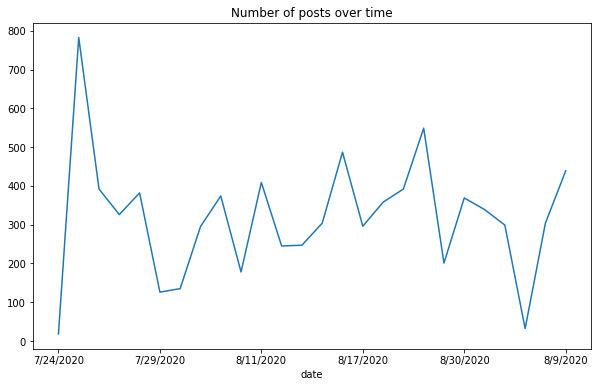

In [92]:
#number of tweets over time
twitter_data.groupby('date').size().plot(title="Number of posts over time", figsize=(10,6))

### Tweets by followers

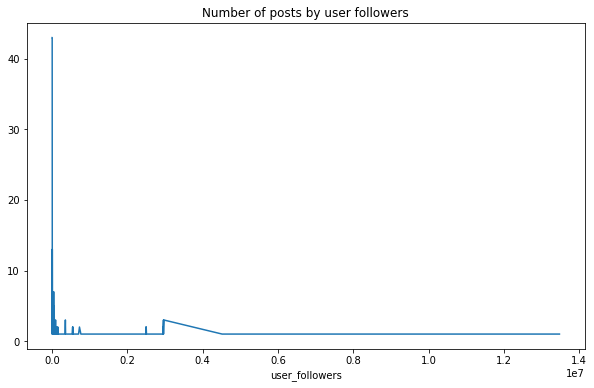

In [94]:
twitter_data.groupby('user_followers').size().plot(title="Number of posts by user followers", figsize=(10,6))

# Machine learning

## Remove stopwords and punctuation, etc

In [95]:
#Removing Punctuation
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0–9]+', '', text)
    return text
twitter_data['punct'] = twitter_data['text'].apply(lambda x: remove_punct(x))

#Applying tokenization- splitting a phrase, sentence, paragraph, or an entire text document into smaller units
def tokenization(text):
    text = re.split('\W+', text)
    return text
twitter_data['tokenized'] = twitter_data['punct'].apply(lambda x: tokenization(x.lower()))

#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
twitter_data['nonstop'] = twitter_data['tokenized'].apply(lambda x: remove_stopwords(x))

#Applying Stemmer
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text
twitter_data['stemmed'] = twitter_data['nonstop'].apply(lambda x: stemming(x))

#Cleaning Text
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text
    
twitter_data.head()

,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,text_nohash,punct,tokenized,nonstop,stemmed
57,"New Orleans, LA",11,3,133,False,7/25/2020,Crazy that the world has come to this but as A...,['covid19'],Crazy that the world has come to this but as A...,Crazy that the world has come to this but as A...,"[crazy, that, the, world, has, come, to, this,...","[crazy, world, come, americans, fight, get, co...","[crazi, world, come, american, fight, get, cov..."
61,astroworld,624,950,18775,False,7/25/2020,I miss isopropyl alcohol so much!!!! Ethanol i...,['COVID19'],I miss isopropyl alcohol so much!!!! Ethanol i...,I miss isopropyl alcohol so much Ethanol in ha...,"[i, miss, isopropyl, alcohol, so, much, ethano...","[miss, isopropyl, alcohol, much, ethanol, hand...","[miss, isopropyl, alcohol, much, ethanol, hand..."
102,"near Austin, Texas",876,777,1640,False,7/25/2020,Not only is the area about to be hit by #hanna...,"['hanna', 'COVID19']",Not only is the area about to be hit by a ho...,Not only is the area about to be hit by hanna ...,"[not, only, is, the, area, about, to, be, hit,...","[area, hit, hanna, covid1, hotspot, hurricane,...","[area, hit, hanna, covid1, hotspot, hurrican, ..."
103,"Toronto, Ontario, Canada",738,143,28004,False,7/25/2020,1.28% of the U.S. population is infected with ...,"['COVID19', 'TrumpVirus', 'MaskItOrCasket']",1.28% of the U.S. population is infected with ...,128 of the US population is infected with Covi...,"[128, of, the, us, population, is, infected, w...","[128, us, population, infected, covid1, covid1...","[128, us, popul, infect, covid1, covid1, trump..."
118,Universe,2181,1928,25969,False,7/25/2020,If CM of Madhya Pradesh is tested positive for...,['COVID19'],If CM of Madhya Pradesh is tested positive for...,If CM of Madhya Pradesh is tested positive for...,"[if, cm, of, madhya, pradesh, is, tested, posi...","[cm, madhya, pradesh, tested, positive, covid,...","[cm, madhya, pradesh, test, posit, covid, scin..."


## Lexicon sentiment analysis

In [96]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [97]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

text_test = "my cat is FRIGGIN cute"

score = SentimentIntensityAnalyzer().polarity_scores(text_test)

print(score)


{'neg': 0.0, 'neu': 0.498, 'pos': 0.502, 'compound': 0.6157}


### Compute sentiment scores and append to dataframe:

In [98]:
for index,row in twitter_data['text'].iteritems():
  # compute a score
  score = SentimentIntensityAnalyzer().polarity_scores(row)
    # Assign score categories to variables
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
    
    # If negative score (neg) is greater than positive score (pos), then the text should be categorized as "negative"
  if neg> pos:
    twitter_data.loc[index,"sentiment"] = 'negative'
    # If positive score (pos) is greater than the negative score (neg), then the text should be categorized as "positive"
  elif pos > neg:
    twitter_data.loc[index,"sentiment"] = "positive"
    # Otherwise 
  else:
    twitter_data.loc[index,"sentiment"] = "neutral"

  twitter_data.loc[index,'neg'] = neg
  twitter_data.loc[index,'pos'] = pos
  twitter_data.loc[index,'neu'] = neu
  twitter_data.loc[index,'compound'] = comp

In [99]:
twitter_data['sentiment'].unique()

array(['negative', 'positive', 'neutral'], dtype=object)

In [100]:
# take a look at how many are labelled positive, negative or neutral
tw_list_negative = twitter_data[twitter_data['sentiment']=='negative']
tw_list_positive = twitter_data[twitter_data['sentiment']=='positive']
tw_list_neutral = twitter_data[twitter_data['sentiment']=='neutral']

# count how many of these values belong to each category. We will define a function to count values.
def count_values_in_column(data,feature):
    
    total = data.loc[:,feature].value_counts(dropna=False)
    percentage = round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    
    return pd.concat([total,percentage],axis=1, keys=['Total', 'Percentage'])

# Values for sentiment
pc = count_values_in_column(twitter_data, "sentiment")

pc

,Total,Percentage
positive,2826,34.13
neutral,2760,33.34
negative,2693,32.53


[2826, 2760, 2693]


Text(0.5, 1.0, 'New classification of sentiments')

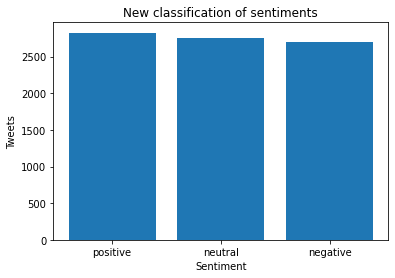

In [101]:
sentiment_count = twitter_data['sentiment'].value_counts()
sentiment_count = [2826,2760,2693]
names = twitter_data['sentiment']
print(sentiment_count)
plt.bar(['positive','neutral','negative'], sentiment_count)
plt.xlabel("Sentiment")
plt.ylabel("Tweets")
plt.title("New classification of sentiments")

[36840, 36755, 25534]


Text(0.5, 1.0, "Sentiment classified with original 'text' column")

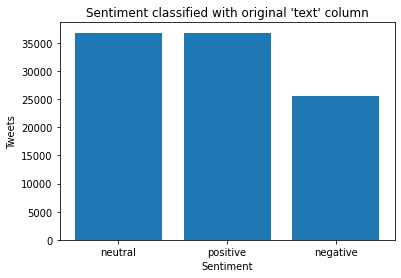

In [45]:
#old sentiment percentages
sentiment_count = twitter_data['sentiment'].value_counts()
sentiment_count = [36840,36755,25534]
names = twitter_data['sentiment']
print(sentiment_count)
plt.bar(['neutral','positive','negative'], sentiment_count)
plt.xlabel("Sentiment")
plt.ylabel("Tweets")
plt.title("Sentiment classified with original 'text' column")

positive > neutral < negative. surprising bc COVID seemed to have caused serioud issues for the economy and made everybody's life difficult. However, we should take a look at locations and find out the most frequent locations (countries) people are posting in. This may be extremely informative on why the sentiments in the tweets contrast general expectations. we can also look at what the news was reporting during this timeframe and see whether it was mass media that somehow influenced people's emotions. Finally though: people could just be bringing up trump, and the algorithm does not know it is a person's name and not the word "trump".

In [ ]:
#twitter_data.to_csv("/content/drive/My Drive/Colab Notebooks/files/project/covid19_twitter_sentiment.csv")

## Tweet length and word count


In [102]:
#Calculating tweet’s length and word count
twitter_data['text_len'] = twitter_data['text'].astype(str).apply(len)
twitter_data['text_word_count'] = twitter_data['text'].apply(lambda x: len(str(x).split()))
round(pd.DataFrame(twitter_data.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,94.02
neutral,85.38
positive,96.98


In [103]:
round(pd.DataFrame(twitter_data.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
negative,15.23
neutral,13.24
positive,15.54


## Tweets by sentiment

In [104]:
#twitter_data[twitter_data['pos']==max(twitter_data['pos'])]

twitter_data[['text','pos']].sort_values(by='pos', ascending=False)[1:10]

,text,pos
8572,#Covid19 positive,0.783
92426,survived #COVID19. bless up! Very thankful.,0.776
162030,Thanks for sharing. \n#COVID19,0.740
161047,Stay Alive. Stay Safe. #COVID19\n\nGood Mornin...,0.689
172023,#COVID19 please take Good Care of them,0.677
60704,I sincerely hope it wasn't #Covid19.,0.667
178174,Good luck reaching there without getting a #...,0.658
6181,"It’s okay! Love you, Stay safe! #Covid19 #Rich",0.657
178948,#COVID19 positive 💔💔💔,0.643


There seems to be some sarcasm the algorithm did not pick up, although I can't be sure either.

In [105]:
#twitter_data[twitter_data['neg']==max(twitter_data['neg'])]

twitter_data[['text','neg']].sort_values(by='neg', ascending=False)[1:10]

,text,neg
91000,#COVID19 negative,0.787
12232,I hate #COVID19.,0.787
104429,Fuck fuck fuck..\n#COVID19,0.778
129375,Stupid #COVID19,0.773
43685,#COVID19 sadly.,0.737
103938,Crap #COVID19,0.722
36002,Damn that sucks #COVID19,0.722
28425,The fear mongering propaganda machine #COVID19,0.700
113806,#Covid19 killed #TriniLopez too :-(,0.700


In [106]:
twitter_data[['text','neu']].sort_values(by='neu', ascending=False)[1:10]

,text,neu
51883,"Nope, the curve has not flattened. #COVID19 #F...",1.0
121304,What if bat samples *are* the origin of #C...,1.0
51527,Same as every other weekend in 2020. #Covid...,1.0
121271,#LiveUpdate: The gov't will reduce the price o...,1.0
121241,Now that it's proven again n again that #Hcqs ...,1.0
51612,Prediction: if 45 keeps divebombing into #COVI...,1.0
121240,How about #COVID19,1.0
51710,It MAY be out of your realm #DrFauci but you'r...,1.0
121051,"Global Cases 20,634,064 Global Deaths\n749,57...",1.0


## Wordclouds

In [107]:
#Function to Create Wordcloud
def create_wordcloud(text):
    mask = np.array(Image.open("/content/drive/My Drive/Colab Notebooks/files/project/twitter_wordcloud_blank.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(
        background_color="white",
        mask = mask,
        max_words=3000,
        stopwords=stopwords,
        repeat=True)
    wc.generate(str(text))
    wc.to_file("/content/drive/My Drive/Colab Notebooks/files/project/twitter_wordcloud.png")
    print("Word Cloud Saved Successfully")
    path="/content/drive/My Drive/Colab Notebooks/files/project"
    display(Image.open(path))

In [ ]:
#dataset = twitter_data['text']
#dataset = str(dataset)
#dataset.lower()

### Positive, negative, and neutral wordclouds

In [108]:
text = twitter_data.query("sentiment == 'positive'")['text']

In [109]:
import matplotlib.pyplot as pPlot
from wordcloud import WordCloud, STOPWORDS
import numpy as npy
from PIL import Image

text = twitter_data.query("sentiment == 'positive'")['text']
dataset = text
def create_word_cloud(string):
  maskArray = npy.array(Image.open("/content/drive/My Drive/Colab Notebooks/files/project/twitter_wordcloud_blank.png"))
  cloud = WordCloud(background_color = "white", max_words = 400, mask = maskArray, stopwords = set(STOPWORDS))
  cloud.generate(string)
  cloud.to_file("/content/drive/My Drive/Colab Notebooks/files/project/pos_wordcloud.png")
dataset = str(dataset).lower() #must convert dataset into string to make this work. also cannot use .str(), has to be str(dataset)
create_word_cloud(dataset)

In [110]:
text = twitter_data.query("sentiment == 'negative'")['text']
dataset = text
def create_word_cloud(string):
  maskArray = npy.array(Image.open("/content/drive/My Drive/Colab Notebooks/files/project/twitter_wordcloud_blank.png"))
  cloud = WordCloud(background_color = "white", max_words = 400, mask = maskArray, stopwords = set(STOPWORDS))
  cloud.generate(string)
  cloud.to_file("/content/drive/My Drive/Colab Notebooks/files/project/neg_wordcloud.png")
dataset = str(dataset).lower() #must convert dataset into string to make this work. also cannot use .str(), has to be str(dataset)
create_word_cloud(dataset)

#### Alternative

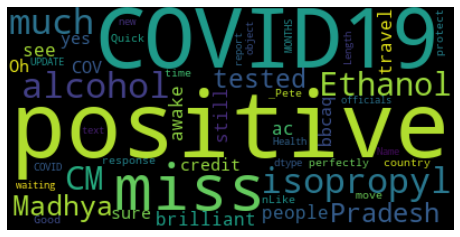

In [114]:
#another way to make wordclouds

from wordcloud import WordCloud
from matplotlib import pyplot as plt
from matplotlib import figure

text = twitter_data.query("sentiment == 'positive'")['text']
#remove_covid19 = lambda x: re.sub("covid19","",x)
remove_dtype = lambda x: re.sub(" dtype ","",x)
text = text.map(remove_dtype)
text = str(text) #convert to string so that .generate() can loop through

plt.figure(figsize=(8, 8))
stopword = nltk.corpus.stopwords.words('english')
wc = WordCloud(max_words=1000, stopwords=stopword)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig("wordcloud_covid")

positive wordcloud.

strange: 'dtype' was in the wordcloud. this part probably needs to use the specified approach and set words that we will or will not include.

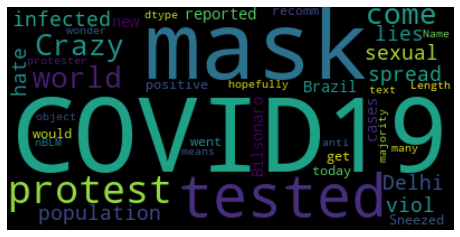

In [116]:
text = twitter_data.query("sentiment == 'negative'")['text']
#remove_covid19 = lambda x: re.sub("covid19","",x)
#text = text.map(remove_covid19) #remove the phrase covid19 because it occurred too many times and may hinder other words from showing up
text = str(text) #convert to string so that .generate() can loop through

plt.figure(figsize=(8, 8))
stopword = nltk.corpus.stopwords.words('english')
wc = WordCloud(max_words=1000, stopwords=stopword)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig("wordcloud_covid")

negative wordcloud.

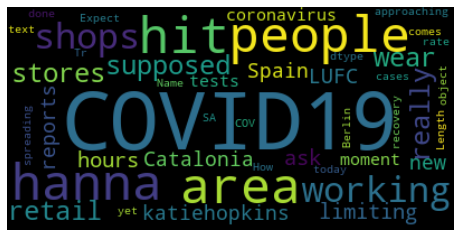

In [118]:
text = twitter_data.query("sentiment == 'neutral'")['text']
#remove_covid19 = lambda x: re.sub("covid19","",x)
#remove_covid19 = lambda x: re.sub("covid","",x)
#text = text.map(remove_covid19) #remove the phrase covid19 because it occurred too many times and may hinder other words from showing up
text = str(text)

plt.figure(figsize=(8, 8))
stopword = nltk.corpus.stopwords.words('english')
wc = WordCloud(max_words=1000, stopwords=stopword)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig("wordcloud_covid")

neutral wordcloud.

### Top 10 locations (by country)

In [115]:
text = twitter_data.query("user_location == 'India' or user_location == 'New Delhi, India'")['text']
dataset = text
def create_word_cloud(string):
  maskArray = npy.array(Image.open("/content/drive/My Drive/Colab Notebooks/files/project/twitter_wordcloud_blank.png"))
  cloud = WordCloud(background_color = "white", max_words = 400, mask = maskArray, stopwords = set(STOPWORDS))
  cloud.generate(string)
  cloud.to_file("/content/drive/My Drive/Colab Notebooks/files/project/India_wordcloud.png")
dataset = str(dataset).lower() #must convert dataset into string to make this work. also cannot use .str(), has to be str(dataset)
create_word_cloud(dataset)

In [119]:
text = twitter_data.query("user_location == 'Hong Kong'")['text']
dataset = text
def create_word_cloud(string):
  maskArray = npy.array(Image.open("/content/drive/My Drive/Colab Notebooks/files/project/twitter_wordcloud_blank.png"))
  cloud = WordCloud(background_color = "white", max_words = 400, mask = maskArray, stopwords = set(STOPWORDS))
  cloud.generate(string)
  cloud.to_file("/content/drive/My Drive/Colab Notebooks/files/project/HK_wordcloud.png")
dataset = str(dataset).lower() #must convert dataset into string to make this work. also cannot use .str(), has to be str(dataset)
create_word_cloud(dataset)

In [120]:
text = twitter_data.query("user_location == 'Canada'")['text']
dataset = text
def create_word_cloud(string):
  maskArray = npy.array(Image.open("/content/drive/My Drive/Colab Notebooks/files/project/twitter_wordcloud_blank.png"))
  cloud = WordCloud(background_color = "white", max_words = 400, mask = maskArray, stopwords = set(STOPWORDS))
  cloud.generate(string)
  cloud.to_file("/content/drive/My Drive/Colab Notebooks/files/project/Canada_wordcloud.png")
dataset = str(dataset).lower() #must convert dataset into string to make this work. also cannot use .str(), has to be str(dataset)
create_word_cloud(dataset)

In [121]:
text = twitter_data.query("user_location == 'USA' or user_location == 'Florida, USA' or user_location == 'Los Angeles, USA'")['text']
dataset = text
def create_word_cloud(string):
  maskArray = npy.array(Image.open("/content/drive/My Drive/Colab Notebooks/files/project/twitter_wordcloud_blank.png"))
  cloud = WordCloud(background_color = "white", max_words = 400, mask = maskArray, stopwords = set(STOPWORDS))
  cloud.generate(string)
  cloud.to_file("/content/drive/My Drive/Colab Notebooks/files/project/USA_wordcloud.png")
dataset = str(dataset).lower() #must convert dataset into string to make this work. also cannot use .str(), has to be str(dataset)
create_word_cloud(dataset)

In [122]:
text = twitter_data.query("user_location == 'Ibadan, Nigeria'")['text']
dataset = text
def create_word_cloud(string):
  maskArray = npy.array(Image.open("/content/drive/My Drive/Colab Notebooks/files/project/twitter_wordcloud_blank.png"))
  cloud = WordCloud(background_color = "white", max_words = 400, mask = maskArray, stopwords = set(STOPWORDS))
  cloud.generate(string)
  cloud.to_file("/content/drive/My Drive/Colab Notebooks/files/project/Nigeria_wordcloud.png")
dataset = str(dataset).lower() #must convert dataset into string to make this work. also cannot use .str(), has to be str(dataset)
create_word_cloud(dataset)

In [123]:
text = twitter_data.query("user_location == 'London, England'")['text']
dataset = text
def create_word_cloud(string):
  maskArray = npy.array(Image.open("/content/drive/My Drive/Colab Notebooks/files/project/twitter_wordcloud_blank.png"))
  cloud = WordCloud(background_color = "white", max_words = 400, mask = maskArray, stopwords = set(STOPWORDS))
  cloud.generate(string)
  cloud.to_file("/content/drive/My Drive/Colab Notebooks/files/project/London_wordcloud.png")
dataset = str(dataset).lower() #must convert dataset into string to make this work. also cannot use .str(), has to be str(dataset)
create_word_cloud(dataset)

In [124]:
text = twitter_data.query("user_location == 'China'")['text']
dataset = text
def create_word_cloud(string):
  maskArray = npy.array(Image.open("/content/drive/My Drive/Colab Notebooks/files/project/twitter_wordcloud_blank.png"))
  cloud = WordCloud(background_color = "white", max_words = 400, mask = maskArray, stopwords = set(STOPWORDS))
  cloud.generate(string)
  cloud.to_file("/content/drive/My Drive/Colab Notebooks/files/project/China_wordcloud.png")
dataset = str(dataset).lower() #must convert dataset into string to make this work. also cannot use .str(), has to be str(dataset)
create_word_cloud(dataset)

## Bigrams

In [168]:
twitter_data.head(3)

,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,text_nohash,punct,tokenized,nonstop,stemmed,sentiment,neg,pos,neu,compound,text_len,text_word_count
57,"New Orleans, LA",11,3,133,False,7/25/2020,Crazy that the world has come to this but as A...,['covid19'],Crazy that the world has come to this but as A...,Crazy that the world has come to this but as A...,"[crazy, that, the, world, has, come, to, this,...","[crazy, world, come, americans, fight, get, co...","[crazi, world, come, american, fight, get, cov...",negative,0.241,0.000,0.759,-0.6588,108,19
61,astroworld,624,950,18775,False,7/25/2020,I miss isopropyl alcohol so much!!!! Ethanol i...,['COVID19'],I miss isopropyl alcohol so much!!!! Ethanol i...,I miss isopropyl alcohol so much Ethanol in ha...,"[i, miss, isopropyl, alcohol, so, much, ethano...","[miss, isopropyl, alcohol, much, ethanol, hand...","[miss, isopropyl, alcohol, much, ethanol, hand...",positive,0.071,0.306,0.623,0.7405,114,20
102,"near Austin, Texas",876,777,1640,False,7/25/2020,Not only is the area about to be hit by #hanna...,"['hanna', 'COVID19']",Not only is the area about to be hit by a ho...,Not only is the area about to be hit by hanna ...,"[not, only, is, the, area, about, to, be, hit,...","[area, hit, hanna, covid1, hotspot, hurricane,...","[area, hit, hanna, covid1, hotspot, hurrican, ...",neutral,0.000,0.000,1.000,0.0000,111,21


In [264]:
from nltk import bigrams
from nltk import trigrams

#change data below for bigrams
data = twitter_data.query("user_location == 'USA' or user_location == 'Florida, USA' or user_location == 'Los Angeles, USA'")['nonstop']
#data = twitter_data['nonstop']

terms_bigram = [list(bigrams(text)) for text in data]

In [265]:
import itertools
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(50)

[(('confirmed', 'deaths'), 15),
 (('deaths', 'covid1'), 15),
 (('confirmed', 'cases'), 7),
 (('cases', 'covid1'), 7),
 (('covid1', 'coronavirus'), 4),
 (('get', 'covid1'), 3),
 (('coronavirus', 'covid1'), 3),
 (('covid', 'covid1'), 3),
 (('died', 'covid1'), 3),
 (('coronavirus', 'andorra'), 2),
 (('andorra', 'total'), 2),
 (('total', '52'), 2),
 (('52', 'confirmed'), 2),
 (('total', '2'), 2),
 (('2', 'confirmed'), 2),
 (('covid1', ''), 2),
 (('trump', 'covid1'), 2),
 (('', 'would'), 2),
 (('covid1', 'hoax'), 2),
 (('covid1', 'deaths'), 2),
 (('', 'covid1'), 2),
 (('die', 'covid1'), 2),
 (('covid1', 'kills'), 2),
 (('', 'get'), 2),
 (('', 'jordan'), 2),
 (('played', 'golf'), 2),
 (('', 'right'), 2),
 (('mask', 'mask'), 2),
 (('coronavirus', 'covid'), 2),
 (('coronavirus', 'nigeria'), 1),
 (('nigeria', 'total'), 1),
 (('total', '353'), 1),
 (('353', 'confirmed'), 1),
 (('coronavirus', 'egypt'), 1),
 (('egypt', 'total'), 1),
 (('total', '4518'), 1),
 (('4518', 'confirmed'), 1),
 (('corona

In [283]:
bigram_df = pd.DataFrame(bigram_counts.most_common(28),
                             columns=['bigram', 'count'])

bigram_df

,bigram,count
0,"(confirmed, deaths)",15
1,"(deaths, covid1)",15
2,"(confirmed, cases)",7
3,"(cases, covid1)",7
4,"(covid1, coronavirus)",4
5,"(get, covid1)",3
6,"(coronavirus, covid1)",3
7,"(covid, covid1)",3
8,"(died, covid1)",3
9,"(coronavirus, andorra)",2


### Network of bigrams

In [ ]:
!pip install cdlib

In [284]:
import networkx as nx
from networkx.algorithms import community
from cdlib import algorithms

# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

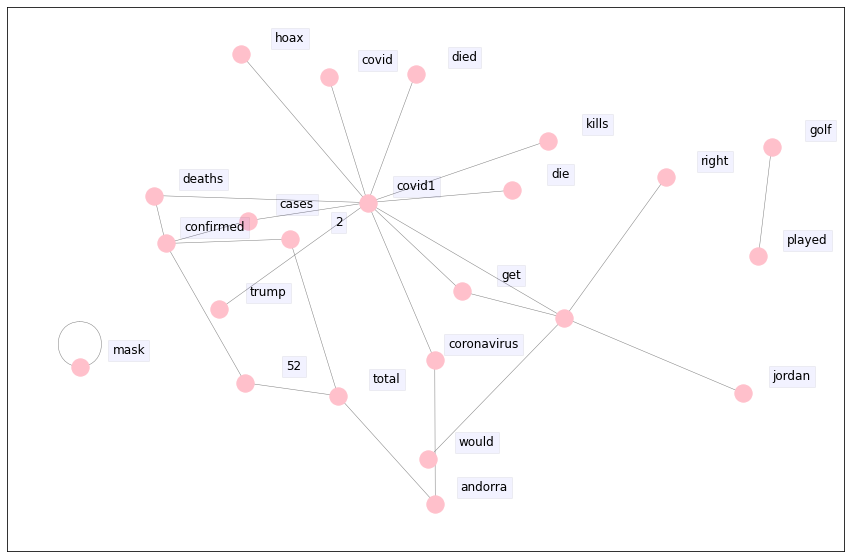

In [286]:
fig, ax = plt.subplots(figsize=(15, 10))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=30,
                 width=0.5,
                 edge_color='grey',
                 node_color='pink',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='blue', alpha=0.05),
            horizontalalignment='center', fontsize=12)
    
plt.show()

### Community

In [ ]:
#comm = community.girvan_newman(G)
#top_level_communities = next(comm)
#next_level_communities = next(comm)
#sorted(map(sorted, next_level_communities))

In [287]:
comm = community.girvan_newman(G)

node_groups = []
for com in next(comm):
  node_groups.append(list(com))

print(node_groups)

[['covid', 'covid1', 'confirmed', 'kills', 'died', 'hoax', 'coronavirus', '52', 'die', 'cases', '2', 'trump', 'deaths', 'andorra', 'total'], ['', 'would', 'right', 'get', 'jordan'], ['played', 'golf'], ['mask']]


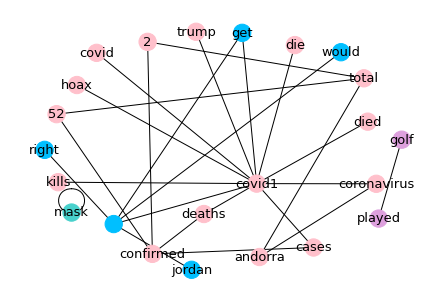

In [288]:
from networkx.algorithms.community.centrality import girvan_newman

color_map = []
for node in G:
    if node in node_groups[0]:
        color_map.append('pink')
    elif node in node_groups[1]:
        color_map.append('deepskyblue')
    elif node in node_groups[2]:
        color_map.append('plum')
    else: 
      color_map.append('mediumturquoise')

pos = nx.spring_layout(G, k=6, scale=20)
nx.draw(G, pos, node_color=color_map, with_labels=True, font_size=13)
plt.show()